Fundamental pytorch data type : the tensor \
it is basically an extension of the NumberWithGrad discussed but for a tensor [the torch equivalent of numpy array with Grad]

In [31]:
from typing import Tuple, List
from collections import deque

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim import Optimizer

import numpy as np
from torch import Tensor

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss

In [32]:
a = torch.tensor([1.,2.,3.], requires_grad=True)
print(a)

tensor([1., 2., 3.], requires_grad=True)


In [33]:
b = a * 4
c = b + 3
d = b * (a+5)
e = c * 2
e_sum = e.sum()
e_sum.backward()

In [34]:
print(a,b,c,d,e,e_sum)

tensor([1., 2., 3.], requires_grad=True) tensor([ 4.,  8., 12.], grad_fn=<MulBackward0>) tensor([ 7., 11., 15.], grad_fn=<AddBackward0>) tensor([24., 56., 96.], grad_fn=<MulBackward0>) tensor([14., 22., 30.], grad_fn=<MulBackward0>) tensor(66., grad_fn=<SumBackward0>)


In [35]:
print(a.grad)

tensor([8., 8., 8.])


The building block of neural network : 
Layer, Model, Loss, Optimizer, Trainer can be written easily now using pytorch's nn module.

In [36]:
def inference_mode(model : nn.Module) -> None:
    model.eval()

class PytorchLayer(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x : torch.Tensor, inference : bool = False) -> torch.Tensor :
        raise NotImplementedError()
    




In [37]:
from typing import Tuple
# base pytorch model
class PytorchModel(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x : torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        raise NotImplementedError()

In [38]:
class DenseLayer(PytorchLayer):
    def __init__(self, in_size : int, neurons : int, dropout : float = 1.,activation : nn.Module = None) :
        super().__init__()
        self.linear = nn.Linear(in_size, neurons)
        self.activation = activation
        if dropout < 1.0:
            self.dropout = nn.Dropout(1. - dropout)
    
    def forward(self, x : torch.Tensor, inference : bool = False) :
        if inference :
            self.apply(inference_mode)
        x = self.linear(x)
        if self.activation:
            x = self.activation(x)
        if hasattr(self, "dropout"):
            x = self.dropout(x)
        
        return x



In [39]:
class HousePricesModel(PytorchModel):
    def __init__(self,hidden_size : int = 8, hidden_dropout : float = 1.):
        super().__init__()
        self.dense1 = DenseLayer(8, hidden_size, hidden_dropout, nn.Sigmoid() )
        self.dense2 = DenseLayer(hidden_size, 1)
    
    def forward(self, x : torch.Tensor):
        assert(len(x.shape) == 2)
        assert(x.shape[1] == 8)
        x = self.dense1(x)
        return self.dense2(x)


        

In [40]:
california_pytorch_model = HousePricesModel(hidden_size=8)


In [41]:
# optimizers and losses are all coded up in pytorch and is easy to use
optimizer = torch.optim.SGD(california_pytorch_model.parameters(), lr=0.001)

In [42]:
mean_squared_loss = nn.MSELoss()
softmax_crossentropy_loss = nn.CrossEntropyLoss()

Though softmax is not explicitly present in the crossEntropyLoss module, it performs softmax on the inputs and then calculates the loss.

In [43]:
def permute_data(X, y):
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]

In [99]:
# Trainer class
class PytorchTrainer(object):
    def __init__(self, model : PytorchModel, optimizer : Optimizer, criterion : _Loss):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self._check_optim_net_aligned()
    def _check_optim_net_aligned(self):
        self.optimizer.param_groups[0]["params"] == list(self.model.parameters())

    def _generate_batches(self, X: torch.Tensor, y : torch.Tensor, size : int = 32) -> Tuple[torch.Tensor]:
        N = X.shape[0]
        for i in range(0,N,size):
            x_batch, y_batch = X[i:i+size], y[i:i+size]
            yield x_batch, y_batch
    
    def fit(self, X_train:torch.Tensor, y_train:torch.Tensor, X_test:torch.Tensor, y_test:torch.Tensor,epochs : int =  100, eval_every : int = 10, batch_size : int = 32):
        X_train, y_train = permute_data(X_train, y_train)
        for e in range(epochs):
            batch_generator = self._generate_batches(X_train, y_train, batch_size)
            for i, (x_batch, y_batch) in enumerate(batch_generator):
                self.optimizer.zero_grad() # zero out the grads
                y_pred = self.model(x_batch)
                loss = self.criterion(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
            if e % eval_every == 0:
                print("Epoch : {}, Loss : {}".format(e,loss.item()))




In [54]:
# train the model on california dataset

from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
data = housing['data']
target = housing['target']
feature_names = housing['target_names']
print(data.shape, target.shape)

(20640, 8) (20640,)


In [55]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target,test_size=0.3, random_state = 42)
y_train, y_test = y_train.reshape(-1,1), y_test.reshape(-1,1)

In [57]:
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [60]:
trainer = PytorchTrainer(california_pytorch_model,optimizer, mean_squared_loss)
trainer.fit(X_train,y_train,X_test,y_test,epochs=10,eval_every=1)

Epoch : 0, Loss : 0.4349268972873688
Epoch : 1, Loss : 0.40333348512649536
Epoch : 2, Loss : 0.3773728311061859
Epoch : 3, Loss : 0.3564622104167938
Epoch : 4, Loss : 0.33990156650543213
Epoch : 5, Loss : 0.32696500420570374
Epoch : 6, Loss : 0.3169691860675812
Epoch : 7, Loss : 0.30931270122528076
Epoch : 8, Loss : 0.30349117517471313
Epoch : 9, Loss : 0.2990948557853699


we see a steady loss in loss which is a good sign. also, the model trained much faster compared to our numpy implementation maybe due to pytorch's optimization underneath [even on CPU cores]

Tricks to Optimize Learning in PyTorch

In [ ]:
#torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9) # for adding momentum to gradient update rule
#nn.Dropout() for adding dropout with p percent of neurons dropped out
# weigh initialization : already taken care of in pytorch Dense layer
# from torch.optim import lr_scheduler

Convolutional neural networks in pytorch

In [100]:
class Conv2DLayer(PytorchLayer):
    def __init__(self, in_channels, out_channels, filter_size, activation, flatten=False, dropout=1.):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, filter_size, padding=filter_size//2)
        self.activation = activation
        self.flatten = flatten
        if dropout < 1. :
            self.dropout = nn.Dropout(1. - dropout)

    
    def forward(self, X):

        x = self.conv(X)
        if self.activation:
            x = self.activation(x)

        if self.flatten:
            x = x.view(x.shape[0],-1)
        if hasattr(self, "dropout"):
            x = self.dropout(x)
        return x
            


In [101]:
#MNIST trainer class

class MNISTConv(PytorchModel):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2DLayer(1,16,5,nn.Tanh(),dropout=0.8)
        self.conv2 = Conv2DLayer(16,8,5,nn.Tanh(), flatten=True,dropout=0.8)
        self.dense1 = DenseLayer(28*28*8, 32, activation=nn.Tanh(), dropout=0.8)
        self.dense2 = DenseLayer(32,10)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dense1(x)
        return self.dense2(x)
    


In [102]:
# MNIST dataset
# the same MNIST dataset
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape(-1,28*28)
test_images = test_images.reshape(-1,28*28)

X_train = (train_images - np.mean(train_images)) / np.std(train_images)
X_test = (test_images - np.mean(test_images)) / np.std(test_images)
y_train = np.zeros((train_labels.size, train_labels.max()+1))
y_train[np.arange(train_labels.size), train_labels] = 1

y_test = np.zeros((test_labels.size, train_labels.max()+1))
y_test[np.arange(test_labels.size), test_labels] = 1

X_train_conv = X_train.reshape(-1,1,28,28)
X_test_conv = X_test.reshape(-1,1,28,28)

X_train_conv = torch.from_numpy(X_train_conv.astype(np.float32))
X_test_conv = torch.from_numpy(X_test_conv.astype(np.float32))

y_test = torch.from_numpy(y_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))

In [103]:
model = MNISTConv()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.9)

trainer = PytorchTrainer(model, optimizer, criterion)
trainer.fit(X_train_conv, y_train, X_test_conv, y_test, epochs=5, eval_every=1)



Epoch : 0, Loss : 0.09561838209629059
Epoch : 1, Loss : 0.08975420892238617
Epoch : 2, Loss : 0.061294347047805786
Epoch : 3, Loss : 0.021063514053821564
Epoch : 4, Loss : 0.01460924930870533


In [104]:
results = model(X_test_conv)


In [106]:
results.shape, y_test.shape

(torch.Size([10000, 10]), torch.Size([10000, 10]))

In [110]:
acc = (torch.argmax(results,dim=1) == torch.argmax(y_test, dim=1)).sum() / 100
print("accuracy on test set is : {} percent".format(acc.item()))

accuracy on test set is : 97.0 percent


LSTMs in pytorch

In [111]:
class LSTMLayer(PytorchLayer):
    def __init__(self,sequence_length, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.sequence_length = sequence_length
        self.h_init = torch.zeros(1,self.hidden_size)
        self.c_init = torch.zeros(1,self.hidden_size)
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, batch_first = True)
        self.fc = DenseLayer(self.hidden_size,self.output_size)
    
    def _transform_hidden_batch(self, hidden, batch_size, before_layer = False):
        if before_layer:
            hidden.repeat(batch_size,1).view(batch_size, 1, self.hidden_size).permute(1,0,2)
        else:
            hidden.permute(1,0,2).mean(dim=0)
    
    
    def forward(self,x):
        batch_size = x.shape[0]
        assert(x.shape[1] == self.sequence_length)
        h_layer = self._transform_hidden_batch(self.h_init, batch_size, before_layer=True)
        c_layer = self._transform_hidden_batch(self.c_init, batch_size, before_layer=True)

        x = self.lstm(x, (h_layer, c_layer))
        self.h_init = self._transform_hidden_batch(h_layer, batch_size, before_layer = False).detach()
        self.c_init = self._transform_hidden_batch(c_layer, batch_size, before_layer = False).detach()
        x = self.fc(x)
        return x





This way we can create a LSTM Layer which can be conveniently used in a LSTM model class and a LSTM trainer can be used to generate texts like how we did in the Recurrent_NN notebook

Unsupervised learning in pytorch : Autoencoders

in supervised learning, we have labels and the model is trained to first learn representations of patterns in data and then use these labels to steer the model to predict these labels correctly. In supervised learning, we do not have any labels, so then , how do we learn representations of patterns in data and then use these for any task like clustering, outlier detection etc. \
One way of doing it through autoencoders, where the labels is the training image itself and the model is required to reconstruct the image. the model has layers which increasingly encode the image into a lower dimensional representation and then a decoder reconstructs these latent representations into an approximation of the image


In [151]:
class Encoder(PytorchModel):
    def __init__(self, hidden_size : int = 28):
        super(Encoder, self).__init__()
        self.conv1 = Conv2DLayer(1, 14,5, activation=nn.Tanh() )
        self.conv2 = Conv2DLayer(14, 7, 5,activation=nn.Tanh(),flatten=True )
        self.dense1 = DenseLayer(28*28*7, hidden_size, activation=nn.Tanh())
    
    def forward(self,x):
        assert(len(x.shape)==4)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dense1(x)
        return x
    
    


In [165]:
class Decoder(PytorchModel):
    def __init__(self, hidden_size = 28):
        super(Decoder,self).__init__()
        self.dense1 = DenseLayer(hidden_size, 28*28*7,activation=nn.Tanh())
        self.conv1 = Conv2DLayer(7, 14,5, activation=nn.Tanh())
        self.conv2 = Conv2DLayer(14, 1, 5,activation=nn.Tanh())
    
    def forward(self,x):
        assert(len(x.shape)==2)

        x = self.dense1(x)
        x = x.view(-1,7,28,28)
        x = self.conv1(x)

        x = self.conv2(x)

        return x


Here we are working with stride = 1, but when stride > 1, we will see a reduction is size with more and more convolution layers added.to retrieve back the image in input resolution, we do conv2d transpose which is supported in pytorch

In [166]:
class AutoEncoder(PytorchModel):
    def __init__(self, hidden_size = 28):
        super(AutoEncoder,self).__init__()
        self.encoder = Encoder(hidden_size)
        self.decoder = Decoder(hidden_size)
    
    def forward(self, x):

        assert(len(x.shape) == 4)

        encoding = self.encoder(x)

        x = self.decoder(encoding)

        return (x,encoding)

In [173]:
# Trainer class
class PytorchTrainer_updated(object):
    def __init__(self, model : PytorchModel, optimizer : Optimizer, criterion : _Loss):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self._check_optim_net_aligned()
    def _check_optim_net_aligned(self):
        self.optimizer.param_groups[0]["params"] == list(self.model.parameters())

    def _generate_batches(self, X: torch.Tensor, y : torch.Tensor, size : int = 32) -> Tuple[torch.Tensor]:
        N = X.shape[0]
        for i in range(0,N,size):
            x_batch, y_batch = X[i:i+size], y[i:i+size]
            yield x_batch, y_batch
    
    def fit(self, X_train:torch.Tensor, y_train:torch.Tensor, X_test:torch.Tensor, y_test:torch.Tensor,epochs : int =  100, eval_every : int = 10, batch_size : int = 32,final_lr_exp: int = None):
        init_lr = self.optimizer.param_groups[0]['lr']
        if final_lr_exp:
            decay = (final_lr_exp / init_lr) ** (1.0 / (epochs + 1))
            scheduler = lr_scheduler.ExponentialLR(self.optim, gamma=decay)
        for e in range(epochs):
            X_train, y_train = permute_data(X_train, y_train)
            batch_generator = self._generate_batches(X_train, y_train, batch_size)
            self.model.train() # trainin mode
            for i, (x_batch, y_batch) in enumerate(batch_generator):
                self.optimizer.zero_grad() # zero out the grads

                y_pred = self.model(x_batch)[0]
                loss = self.criterion(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
            if e % eval_every == 0:
                self.model.eval() # eval mode
                output = self.model(X_test)[0]
                loss = self.criterion(output, y_test)
                print("Epoch : {}, Loss : {}".format(e,loss.item()))

in our model, we have a tanh activation after the nn.Linear() which squashes the output in the range of -1,1 but this is supposed to reconstruct our image which is in a different scale, so we convert our input image to this scale

In [174]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape(-1,28*28)
test_images = test_images.reshape(-1,28*28)

X_train = (train_images - np.mean(train_images)) / np.std(train_images)
X_test = (test_images - np.mean(train_images)) / np.std(train_images)

X_train_conv = X_train.reshape(-1,1,28,28)
X_test_conv = X_test.reshape(-1,1,28,28)

X_train_conv = torch.from_numpy(X_train_conv.astype(np.float32))
X_test_conv = torch.from_numpy(X_test_conv.astype(np.float32))

X_train_auto = (X_train_conv - X_train_conv.min()) / (X_train_conv.max() - X_train_conv.min()) * 2 - 1
X_test_auto = (X_test_conv - X_train_conv.min()) / (X_train_conv.max() - X_train_conv.min()) * 2 - 1

In [175]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [176]:
print(X_train_auto.shape)
print(X_test_auto.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


In [180]:
model = AutoEncoder(28)
model.to(mps_device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)
trainer = PytorchTrainer_updated(model, optimizer, criterion)

trainer.fit(X_train_auto.to(mps_device), X_train_auto.to(mps_device), X_test_auto.to(mps_device), X_test_auto.to(mps_device), epochs=2, batch_size=32)

Epoch : 0, Loss : 0.05582563579082489


In [182]:
reconstructed_images, image_representations = model(X_test_auto.to(mps_device))

In [184]:
reconstructed_images.shape,image_representations.shape

(torch.Size([10000, 1, 28, 28]), torch.Size([10000, 28]))

plot the image and the reconstruction

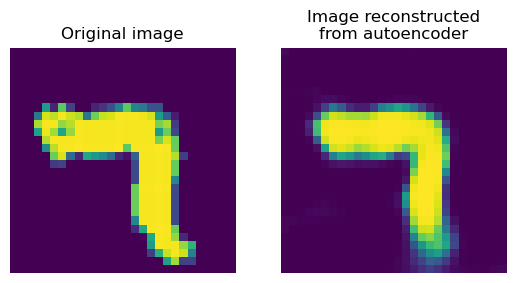

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns
def display_image(ax,
    t: Tensor):
    n = t.detach().numpy()
    ax.imshow(n.reshape(28, 28))

np.random.seed(20190502)
a = np.random.randint(0, 10000)

f, axarr = plt.subplots(1,2)
display_image(axarr[0], X_test_auto[a])
display_image(axarr[1], reconstructed_images.cpu()[a])

axarr[0].set_title("Original image")
axarr[1].set_title("Image reconstructed\nfrom autoencoder")

axarr[0].axis('off')
axarr[1].axis('off');

we see that the model is able to learn some latent representation from which it is able to get back the input image to a reasonable extent